# Lab 2: Transfer Learning & Transformers: Comparison of Transformer Architecture to Other Neural Networks in Evaluation of Movie Reviews and Ratings

Group Members:

- Parker Brown

- Suma Chackola

- Chris Peters

- Oliver Raney



**The execution of this lab was performed collaboratively across 4 computers. Therefore, while the individual cells are not all shown with the direct execution results, the code presented in those cells was utilized to produce the results in this notebook.**


<a id="top"></a>
## Contents
* <a href="#P1">1.0 Introduction & Dataset Overview</a>
* <a href="#P2">2.0 Transfer Learning Foundational Model </a>
* <a href="#P3">3.0 Splitting the Data </a>
* <a href="#P4">4.0 Training a Model from Scratch </a>
* <a href="#P5">5.0 Training a Model by Transfer Learning from Foundational Model </a>
* <a href="#P6">6.0 Fine-Tuning the Model </a>
* <a href="#P6">7.0 Results: Comparing All Investigated Models </a>
________________________________________________________________________________________________________


<a href="#top">Back to Top</a>
<a id="P1"></a>
## 1.0 Introduction & Dataset Overview
#### Give an overview of the dataset you have chosen to use. What is the classification task. Is this multi-task? Explain. What is the feature data? Who collected the data? Why? When? Is the data multi-modal? What evaluation criteria will you be using and why? 

In this lab, we are performing classification on Movie Review text to associate the text of the review with an overall "positivity" rating of Positive, Neutral, or Negative. By reviewing the text as a whole instead of sets of words or phrases, we are evaluating a sequential text to classify it into a distinct category.  

### Dataset Overview
The dataset we are using for this analysis comes from an IEEE Open Access repository at the following source: 
- Data Source: https://ieee-dataport.org/open-access/imdb-movie-reviews-dataset

The dataset compiles movie reviews from the Internet Movie Database (IMDb),  https://www.imdb.com/, and contains 1 million reviews from 1150 movies spread across 17 genres. In this dataset is other metadata such as the IMDb rating and movie rating. The data was compiled by Pal, Barigidad, and Mustafi and utilized and presented as a paper at the 2020 International Conference on Computing, Communication, and Security (ICCCS). In their analysis, they used the content of the movie reviews to classify the genre of the movie through word tokenization and a keyword list specific to the genre, and from their results they created a "Movie Recommender" based on a genre input from a user.

This is not a multi-modal dataset because it only contains textual data. We did not choose a multi-modal dataset, although there are other IMDb datasets that do contain multi-modal data, such as this one: https://arxiv.org/abs/1702.01992, which contains images of the poster of the movie, in addition to the movie genre, rating, and other text. 

### Classification Task
We utilized this dataset in Lab 1 for this course, where we performed sentiment analysis on the movie reviews and compared that sentiment to the movie positivity rating. For this lab, we differentiate that approach by using neural networks with a word embedding vectorizer to train a model. The training will analyze the sequential text in the review and use the associated rating to learn how the overall sequence relates to the positivity with respect to the vectorization of the sequence. Once that association is learned, the model evaluates new review sequences to classify those to an appropriate rating using the same vectorization analysis approach. 

In the dataset, the reviews are rated on a scale of 1-10. With our classifier, we will expect to get a similar scale, so that it is a multi-class classification task. We have considered whether to segment the results into generalized score categories of: Score < 3.5 -> "Negative" , - 3.5 < Score < 6.5 -> "Neutral" , - 6.5 < Score -> "Positive"
However, we don't believe there is much utility in generalizing the results because it could mask the underlying performance of the models. 

### Evaluation Criteria
We are considering a few aspects to evaluate throughout this analysis. First, we will evaluate the model as it is fitting by reviewing the performance of the accuracy and the loss on the training and test datasets so we can ensure the model is both converging and not overfitting. Further, we will consider the convergence time on each model to evaluate the model efficiency (with some allowance/forgiveness to the performance differences of the processors on each of our computers, since it is not guaranteed that the same computer is performing all of the evaluations).

Once each model completes training, we will then utilize the F-score statistical testing as a metric to compare the performance of the models. F-score is an analysis of variance approach (ANOVA) that determines the statistical difference of two or more populations in hypothesis testing by comparing their variances. To do this, we divide the population sample variance between the groups by the variance within the groups to generate the F-score. If the F-score exceeds a certain value, then the null hypothesis can be rejected because the null hypothesis assumes that the variances are equal. If the F-score does not exceed this value, we cannot reject the null hypothesis because the evidence does not provide the conclusion that there is significant differnce in the variance. Source: https://www.geeksforgeeks.org/how-to-perform-an-f-test-in-python/

In the case of this analysis, our null hypothesis is that the use of a transformer model, such as BERT, to analyze review text sequences to predict the overall rating will provide a more accurate classification performance than that of a traditional multi-layer perceptron. Further, we hypothesize that fine tuning BERT for our specific model will show an improved performance over BERT in its unchanged, transferred state.

Because we're ultimately performing a classification task, we should consider not only the accuracy of the predcition, but we should consider the precision & the recall of the classification. For this task, we should consider both False Positives and False Negatives, with the assumption that the rating provided is the true rating for the movie. From a False Positive perspective, if a review provides a rating that is high whereas the rating is low, then the perception of the film is inverted, and a person may expect a masterpiece and instead experience an unsatisfying film. This would be a similar case for the False Negatives, where a review that reads with a low rating but actually has a high rating could lead to a person not experiencing an entertaining movie. Because either of these would defeat the purpose of the model, we should evaluate both Precision, which measures the model performance with respect to False Positives, and Recall, which measures the False Negative rate of the model. Therefore, we will look at maximizing the overall F1 score, which provides a weighted performance of both Precision & Recall so that it takes into account the performance of True Positives, True Negatives, False Positives, and False Negatives. 
We implement this approach using the following source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

<a href="#top">Back to Top</a>
<a id="P2"></a>
## 2.0 Transfer Learning Foundational Model
#### Describe the foundational model that you will be using to transfer learn from. What tasks was this foundational model trained upon? Explain if the new task is within the same domain, across domains, etc. 

### Foundational Model: BERT
In this analysis, we will perform transfer learning with the Bidrectional Encoder Representation (BERT) model (source: https://arxiv.org/abs/1810.04805). BERT was developed by Google for text sequences, and it provides an architecture that can be utilized for a variety of natural language processing tasks and is able to encode the context of statements in two directions, which ensures a greater understanding of the message in the text. BERT has a base version that includes 12 encoder layers with 12 heads per layer and 110M parameters, and it has a large version that includes 24 encoder layers with 16 heads per layer and 340M parameters.

From the original paper, BERT performs bidirectional encoding by using a masked language model that randomly masks tokens in the input to predict the original vocabulary based only on context. The BERT framework can be utilized in two steps: pre-training & fine-tuning, where the model is trained on unlabled data and then fine-tuned with labeled data from downstream tasks. In the paper, the WordPiece embeddings (30k tokens, referenced in BERT paper above) were used to provide the foundational tokenization. For the pre-training, BERT used the BooksCorpus and English Wikipedia, which have 800M and 2500M words, respectively (all referenced in BERT paper above). From Wikipedia, only the text passages were utilized.

Because BERT can be used for a variety of tasks and is text-based, we can say that it is within the same domain as the task we are performing. From its original paper, BERT was built for, among others, question-answering tasks, hypothesis-premise tasks, and sentiment analysis tasks. Our goal is effectively sentiment analysis, where we are evaluating the overall context of the review and to what extent a film was perceived as "good". 

### Fine-Tuning Approach
One advantage of BERT is that it can be fine tuned for a given task. This fine-tuning is readily-available because BERT contains a self-attention mechanism that allows it to model many downstream tasks so that it can encode a concatenated text pair with bidirectional cross attention between two sentences. The fine-tuning tasks are relatively efficient processing-wise compared to the pre-training. One approach to performing this can be found in: https://classic.d2l.ai/chapter_natural-language-processing-applications/finetuning-bert.html.

We will perform fine-tuning through....

<a href="#top">Back to Top</a>
<a id="P3"></a>
## 3.0 Splitting the Data 
#### Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.

The dataset was compiled without regard to the distribution of the rating. In a plot below, we show that the data is heaviliy weighted towards positive reviews (with the majority ratings of 9 or 10). However, there is a substantial number of reviews for all cases. One question to ask is if it is important to maintain the distribution of the ratings, or if it is more important to provide a classifier that can perform equally well regardless of the rating. Because of the distribution, we have a few options for the data:
1) Do no data augmentation & perform a random 80/20 split for Training & Test Data. From a positive perspective, this maintains all the data for evaluation, and the randomness should remove some bias in the results. Further, this is a straightforward splitting task. However, from a negative perspective, we expect bias in the results to remain and be pointed towards the positive entries.

2) Keep an equal number of entries for each rating (Rating of 2 was the lowest quantity). From a positive perspective, this is very significant statistically and should provide satisfactory data. From a negative perspective, we may lose data quality from the diversity of the text provided for different rating values.

3) Perform stratified shuffling & splitting. From a positive perspective, this is an improvement of option 1) in that new, "unexpected" bias, is not introduced through a random sampling. From a negative perspective, it still hold the bias towards the positive entries. However, one could argue that this bias towards a positive rating should be considered a "feature" of the data and perhaps means we should re-evaluate our "upper limit" for a "Neutral" rating. 

We ultimately decided to go with 2) above, where we removed many entries to keep the dataset with an even distribution. We ended with 5000 samples for each of the 10 ratings, which we believe is still statistically significant for this analysis.

### Preparing Data

In [3]:
#imports
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt 


warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [163]:
#https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
# and https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe



directory = 'data/movie_dataset/2_reviews_per_movie_raw'

dfs = list()

#Concatenate data into one pandas dataframe
for filename in os.listdir(directory):	
	data = pd.read_csv(os.path.join(directory, filename), header='infer')	
	dfs.append(data)
df = pd.concat(dfs, ignore_index=True)


df.head()



,username,rating,helpful,total,date,title,review
0,Imme-van-Gorp,7,102,123,30 January 2019,Unfortunately the ending ruined an otherwise ...,This movie is full of suspense. It makes you g...
1,sonofocelot-1,5,385,500,10 May 2016,...oh dear Abrams. Again.\n,I'll leave this review fairly concise. <br/><b...
2,mhodaee,5,110,143,4 August 2017,"Fantastic, gripping, thoroughly enjoyable, un...",I give the 5/10 out of the credit I owe to the...
3,fil-nik09,5,73,100,5 October 2016,Hmmm...\n,"First of all, I must say that I was expecting ..."
4,DVR_Brale,7,42,56,27 July 2016,Slow building & plot alternating claustrophob...,I've always loved movies with strong atmospher...


In [164]:
# retain only rating and review
df = df.drop(columns=['username', 'helpful', 'total', 'date','title'], errors='ignore')

#print unique ratings
df.rating.unique()


array(['7', '5', '9', '8', '10', 'Null', '6', '1', '4', '3', '2'],
      dtype=object)

In [165]:
#drop Null ratings
df = df[~df['rating'].str.contains('Null')]

# Convert "rating" to int
df= df.astype({'rating':'int'})
df.rating.unique()



array([ 7,  5,  9,  8, 10,  6,  1,  4,  3,  2])

In [166]:

# Drop rows where "rating" is NaN or reviews are missing
df = df.dropna(subset=['rating'])
df = df.dropna(subset=['review'])

df.head()

,rating,review
0,7,This movie is full of suspense. It makes you g...
1,5,I'll leave this review fairly concise. <br/><b...
2,5,I give the 5/10 out of the credit I owe to the...
3,5,"First of all, I must say that I was expecting ..."
4,7,I've always loved movies with strong atmospher...


In [167]:
df['review'] = df['review'].str.lower() 
df.head()

,rating,review
0,7,this movie is full of suspense. it makes you g...
1,5,i'll leave this review fairly concise. <br/><b...
2,5,i give the 5/10 out of the credit i owe to the...
3,5,"first of all, i must say that i was expecting ..."
4,7,i've always loved movies with strong atmospher...


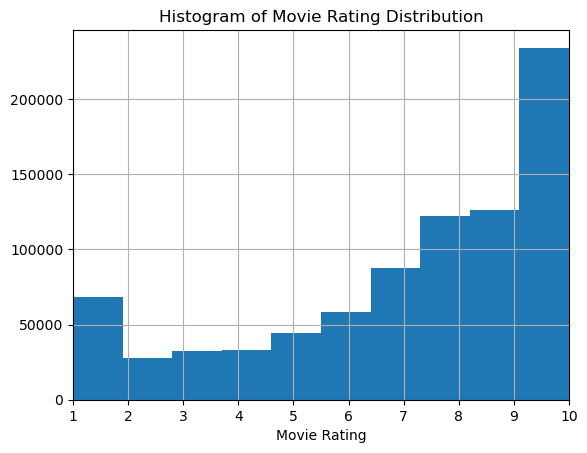

In [168]:
hist = df['rating'].hist(bins=10)
plt.title('Histogram of Movie Rating Distribution') 
plt.xlabel('Movie Rating') 
plt.xlim(1, 10)
plt.show()

We now trim down the dataset so that we have an equal distribution of all ratings.

In [169]:
total_sample_size = 50000
unique_ratings = df['rating'].nunique()
samples_per_category = total_sample_size // unique_ratings  # Integer division to get samples per category

if total_sample_size % unique_ratings != 0:
    print(f"Warning: {total_sample_size} is not evenly divisible by {unique_ratings} categories. " +
          f"Actual total sample size will be {samples_per_category * unique_ratings}.")

# Uniformly sample rows from each rating category
sampled_df = df.groupby('rating').apply(lambda x: x.sample(n=samples_per_category)).reset_index(drop=True)

# Check the final sample size and distribution
print(f"Final sample size: {len(sampled_df)}")
print(sampled_df['rating'].value_counts())
sampled_df.to_csv('sampled_df.csv', index=False)

Final sample size: 50000
1     5000
2     5000
3     5000
4     5000
5     5000
6     5000
7     5000
8     5000
9     5000
10    5000
Name: rating, dtype: int64


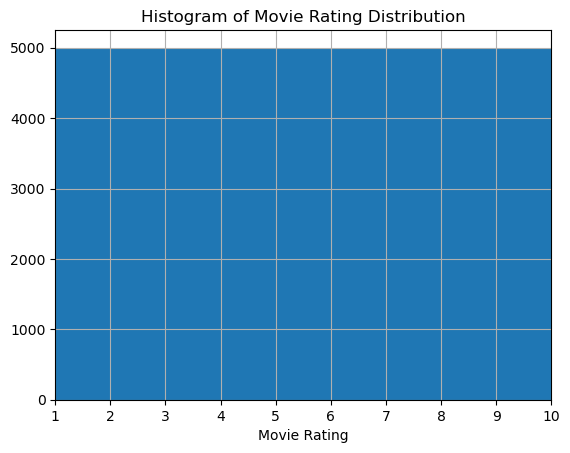

In [170]:
hist = sampled_df['rating'].hist(bins=10)
plt.title('Histogram of Movie Rating Distribution') 
plt.xlabel('Movie Rating') 
plt.xlim(1, 10)
plt.show()

### Clean the data

In [2]:
sampled_df = pd.read_csv('sampled_df.csv')
sampled_df['review'] = sampled_df['review'].fillna('')
sampled_df['review'] = sampled_df['review'].astype(str)

# Clean up text per https://medium.com/@AMustafa4983/sentiment-analysis-on-imdb-movie-reviews-a-beginners-guide-d5136ec74e56

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
 
nltk.download('stopwords')

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def normalize_text(text):
    text = text.lower()
    # get rid of urls
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # get rid of non words and extra spaces
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    #text = remove_stopwords(text)
    #text = stemming(text)
    return text

Xt = [clean_text(text) for text in sampled_df['review'].tolist()]

sampled_df.review = pd.DataFrame(Xt)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [172]:
sampled_df.to_csv('sampled_df.csv', index=False)

<a href="#top">Back to Top</a>
<a id="P4"></a>
## 4.0 Training a Model from Scratch 
#### Train a model from scratch to perform the classification task (this does NOT need to be a transformer). That is, do not use transfer learning for the classification task. Verify the model converges (even if the model is overfit). This does NOT need to mirror the foundational model. This model may be far less computational to train.

We followed an approach that uses an LSTM: 
https://medium.com/@AMustafa4983/sentiment-analysis-on-imdb-movie-reviews-a-beginners-guide-d5136ec74e56

### Model

In [2]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
#import keras

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sampled_df = pd.read_csv('sampled_df.csv')

sampled_df.rating.replace(to_replace = [1,2,3,4,5,6,7,8,9,10], 
               value = [0,0,0,0,0,
                        1,1,1,1,1],
                inplace=True)
sampled_df

,rating,review
0,0,"since the movie sixth sense, i was impressed w..."
1,0,jean grey kills scott summers?? does ratner kn...
2,0,lego should leave the filmmaking business alon...
3,0,i dont understood the point of the move waste ...
4,0,"based on all the good reviews, i rented this m..."
...,...,...
49995,1,fledgling astronaut dr ryan stone (bullock) ve...
49996,1,a series of films of the strongest productions...
49997,1,"it felt a little cliched at times. but wait, m..."
49998,1,this was a great movie and critics did not und...


In [3]:
sampled_df.to_csv('sampled_df_bin.csv', index=False)

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
#import keras

from keras import metrics
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
import tensorflow as tf


# Model hyperparameters
max_length = 100
embedding_dim = 100
num_filters = 128
kernel_size = 5
hidden_dims = 128

# Tokenize
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts((sampled_df['review']).astype(str))
#vocab_size = len(tokenizer.word_index)+1  # Adding 1 to account for the reserved 0 index


### train_test_split

In [7]:
X = sampled_df['review'].astype(str)
y = sampled_df['rating']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   shuffle=True)

### Tokenization

In [8]:
#from keras.preprocessing.text import Tokenizer
# important properties
vocab_size = 10000
max_length = 100

trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

# Define tokenizer and fit on texts
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

# Let's Tokenize and pad texts
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tf.keras.utils.pad_sequences(X_train, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)
X_test = tf.keras.utils.pad_sequences(X_test, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)

### Train Model

In [9]:
from keras.layers import LSTM
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping



model = Sequential()

model.add(Embedding(vocab_size, 64, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout regularization

model.add(LSTM(32, return_sequences=True))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Add dropout regularization

model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Add dropout regularization
    
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

#early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Apply early stopping

In [11]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [10]:
import keras
keras.utils.plot_model(model, to_file='base_model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
batch_size = 250
history = model.fit(X_train,y_train,epochs=15,batch_size=batch_size,validation_split=.2)#,callbacks=[early_stopping])

Epoch 1/15
 22/128 [====>.........................] - ETA: 30s - loss: 0.6928 - accuracy: 0.5142 - f1_m: 0.3592 - precision_m: 0.5314 - recall_m: 0.3615

KeyboardInterrupt: 

### Plot Convergence

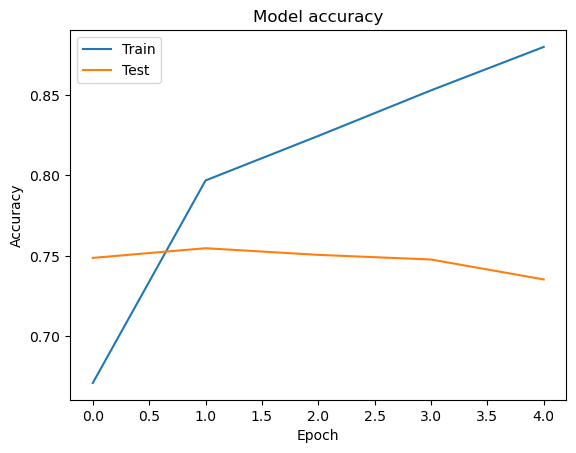

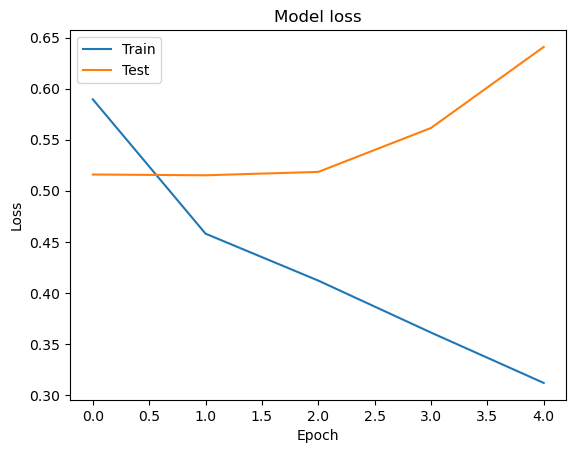

In [58]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [225]:
# Save the training history to a CSV file
histdf_init = pd.DataFrame(history.history)
histdf_init.to_csv('base_model_training_history2bin.csv', index=False)

# Save predictions to a CSV file
y_pred = model.predict(X_test)
results = pd.DataFrame(pd.Series(y_test.to_numpy()),columns=['Actual'])
results['Predicted'] = pd.DataFrame(y_pred)
results.head()
results.to_csv('base_model_predictions2bin.csv', index=False)

# Save the Keras model
model.save('base_model2bin.keras')

313/313 [==============================] - 8s 25ms/step


In [226]:
score = model.evaluate(np.asarray(X_test),np.asarray(y_test))

313/313 [==============================] - 8s 26ms/step - loss: 0.6120 - accuracy: 0.7441 - f1_m: 0.7406 - precision_m: 0.7329 - recall_m: 0.7630


In [227]:
yt = np.array(y_test)
yt = yt.reshape(1,10000)
print(yt)

[[1 0 0 ... 0 0 0]]


In [228]:
yp = np.round(y_pred,0).astype(int)
yp = yp.reshape(1,10000)
print(yp)

[[0 0 1 ... 1 0 0]]


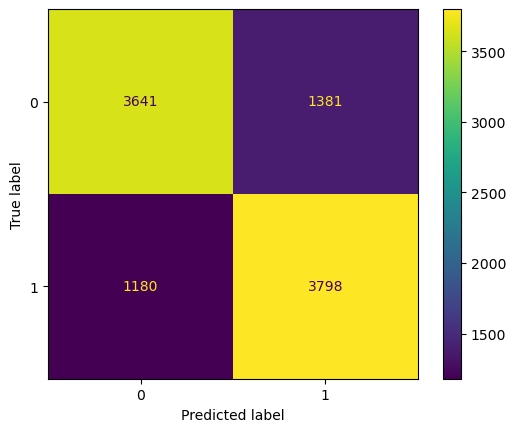

In [229]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
y_predconf = yp.reshape(10000,1)
y_testconf = yt.reshape(10000,1)
conf_mat = confusion_matrix(y_testconf, y_predconf)
cm_display = ConfusionMatrixDisplay(conf_mat).plot()

The training performance converges, both from a loss and an accuracy perspective. The test dataset does not perform as well for this initial model, however, we do achieve around 75% accuracy for both the Validation and Test Data. 
We will now evaluate this task using Transfer Learning to see if we have improvements in the performance.

<a href="#top">Back to Top</a>
<a id="P5"></a>
## 5.0 Training a Model by Transfer Learning from Foundational Model 
#### Train a model by transfer learning from your foundational model. Verify that the new model converges. You only need to train a model using the bottleneck features for this step. 

In [27]:
# Regular imports
import numpy as np
import pandas as pd
import tqdm # for progress bar
import math
import random
import re
import os
import warnings
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Tensorflow Import
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

warnings.filterwarnings('ignore')

import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

import tensorflow as tf

sampled_df = pd.read_csv('sampled_df.csv')
sampled_df['review'] = sampled_df['review'].fillna('')
sampled_df['review'] = sampled_df['review'].astype(str)

X = sampled_df['review'].tolist()
y = sampled_df['rating']-1

y = y.tolist()
#Train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_seq = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

#At first we freeze it, with distil_bert freeze all or none
for layer in distilbert_seq.layers:
    layer.trainable = False

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_159']
You should probably TRAIN this model on a down-stream task to be able to use 

In [63]:
train_encodings = tokenizer.encode(X_train, truncation=True, padding=True, return_tensors="tf")
val_encodings = tokenizer.encode(X_val, truncation=True, padding=True, return_tensors="tf")
test_encodings = tokenizer.encode(X_test, truncation=True, padding=True, return_tensors="tf")


#train_dataset = tf.data.Dataset.from_tensor_slices((
#    dict(train_encodings),
#    y_train
#))
#val_dataset = tf.data.Dataset.from_tensor_slices((
#    dict(val_encodings),
#    y_val
#))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


https://gist.github.com/Galina-Blokh/ee698fe9352b27aa742caac6a4c9482a

https://huggingface.co/assemblyai/distilbert-base-uncased-sst2

In [64]:
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
BATCH_SIZE = 16
N_EPOCHS = 3
MAX_LEN = 100

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
text_list = X_test
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

encodings = tokenizer(text_list, max_length=MAX_LEN, truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(encodings))) 


Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_399']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
#chose the optimizer
optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)
#define the loss function 
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#build the model
model.compile(optimizer=optimizerr,
              loss=losss,
              metrics=['accuracy'])
# train the model 
#model.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE),
#          epochs=N_EPOCHS,
#          batch_size=BATCH_SIZE)

In [66]:
model.evaluate(dataset.shuffle(len(X_test)).batch(BATCH_SIZE), 
               return_dict=True, 
               batch_size=BATCH_SIZE)

AttributeError: in user code:

    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1668, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 652, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'NoneType' object has no attribute 'shape'


In [71]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_399 (Dropout)       multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [72]:
from transformers import TFDistilBertMainLayer

In [74]:
model2 = TFDistilBertMainLayer
model.summary()

Model: "tf_distil_bert_for_sequence_classification_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_399 (Dropout)       multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [75]:
preds = model.predict(dataset.batch(1)).logits

 116/8000 [..............................] - ETA: 11:37

In [ ]:
res = tf.nn.softmax(preds, axis=1).numpy()

In [47]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

tf_output = loaded_model.predict(train_encodings)[0]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_239']
You should probably TRAIN this model on a down-stream task to be able to use 

1/1 [==============================] - 1s 1s/step


In [48]:
tf_output

array([[ 0.07269464, -0.05397585]], dtype=float32)

In [30]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_179']
You should probably TRAIN this model on a down-stream task to be able to use 

In [36]:
bottleneck_features_train = model.predict(train_dataset,verbose=0)
bottleneck_features_val = model.predict(val_dataset,verbose=0)

# Save the bottleneck features and labels
np.save(f'bottleneck_features_train_seqbin.npy', bottleneck_features_train)
np.save(f'bottleneck_features_val_seqbin.npy', bottleneck_features_val)
np.save('ratings_train_seqbin.npy', y_train)
np.save('ratings_val_seqbin.npy', y_val)

StagingError: in user code:

    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\chris\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    StagingError: Exception encountered when calling layer "tf_distil_bert_for_sequence_classification_8" "                 f"(type TFDistilBertForSequenceClassification).
    
    in user code:
    
        File "C:\Users\chris\anaconda3\lib\site-packages\transformers\modeling_tf_distilbert.py", line 743, in call  *
            distilbert_output = self.distilbert(
        File "C:\Users\chris\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        StagingError: Exception encountered when calling layer "distilbert" "                 f"(type TFDistilBertMainLayer).
        
        in user code:
        
            File "C:\Users\chris\anaconda3\lib\site-packages\transformers\modeling_tf_distilbert.py", line 493, in call  *
                embedding_output = self.embeddings(input_ids, inputs_embeds=inputs_embeds)  # (bs, seq_length, dim)
            File "C:\Users\chris\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
        
            StagingError: Exception encountered when calling layer "embeddings" "                 f"(type TFEmbeddings).
            
            in user code:
            
                File "C:\Users\chris\anaconda3\lib\site-packages\transformers\modeling_tf_distilbert.py", line 132, in call  *
                    return self._embedding(inputs, inputs_embeds=inputs_embeds, training=training)
                File "C:\Users\chris\anaconda3\lib\site-packages\transformers\modeling_tf_distilbert.py", line 157, in _embedding  *
                    seq_length = shape_list(input_ids)[1]
            
                IndexError: list index out of range
            
            
            Call arguments received by layer "embeddings" "                 f"(type TFEmbeddings):
              • inputs=tf.Tensor(shape=(512,), dtype=int32)
              • inputs_embeds=None
              • mode=embedding
              • training=False
        
        
        Call arguments received by layer "distilbert" "                 f"(type TFDistilBertMainLayer):
          • inputs={'input_ids': 'tf.Tensor(shape=(512,), dtype=int32)', 'attention_mask': 'tf.Tensor(shape=(512,), dtype=int32)'}
          • attention_mask=None
          • head_mask=None
          • inputs_embeds=None
          • output_attentions=None
          • output_hidden_states=None
          • training=False
    
    
    Call arguments received by layer "tf_distil_bert_for_sequence_classification_8" "                 f"(type TFDistilBertForSequenceClassification):
      • inputs={'input_ids': 'tf.Tensor(shape=(512,), dtype=int32)', 'attention_mask': 'tf.Tensor(shape=(512,), dtype=int32)'}
      • attention_mask=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • labels=None
      • training=False


In [ ]:
model.save_pretrained("pretained_seq_modelbin")
tokenizer.save_pretrained("pretraied_seq_tokensbin")

In [ ]:
def get_predicted_values (outputs, filename_addendum):
    pred_values = []
    for output in outputs:
        #logits = output.logits
        pred_values.append( output.argmax().item())
    
    pred_values = np.vstack(pred_values)
    np.save(f'y_{filename_addendum}_pred_seq.npy', pred_values)
    return pred_values


train_pred_values = get_predicted_values(bottleneck_features_train.logits, 'train')
val_test_values = get_predicted_values(bottleneck_features_val.logits, 'val')

print(val_test_values)

In [ ]:
df = pd.DataFrame(train_pred_values, columns=['PredictedRatings'])
hist = df.hist(bins=2)
plt.title('Histogram of Train Movie Rating Distribution') 
plt.xlabel('Movie Rating') 
plt.xlim(0, 1)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(train_pred_values, y_train)

In [ ]:
accuracy_score(train_pred_values, y_train)

https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

https://databasecamp.de/en/use-case/bert-sentiment-analysis

In [70]:
pip install bert-for-tf2

     ---------------------------------------- 0.0/41.2 kB ? eta -:--:--
     --------- ------------------------------ 10.2/41.2 kB ? eta -:--:--
     ------------------ ------------------- 20.5/41.2 kB 330.3 kB/s eta 0:00:01
     -------------------------------------  41.0/41.2 kB 281.8 kB/s eta 0:00:01
     -------------------------------------- 41.2/41.2 kB 247.3 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30554 sha256=ae81a1a9541474a67848692752e4df2fe26e0e2c620fe275edde654a7c77d16d
  Stored in directory: c:\users\chris\appdata\local\pip\cache\wheels\ab\a4\72\df07592cea3ae06b5e846f5e52262f8b16748e829ca354b7df
  Created wheel f

In [1]:
# Regular imports
import numpy as np
import pandas as pd
import tqdm # for progress bar
import math
import random
import re

# Tensorflow Import
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Bert Import for Tokenizer
import bert
from bert import bert_tokenization
BertTokenizer = bert_tokenization.FullTokenizer

In [11]:
from keras import metrics
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
sampled_df = pd.read_csv('sampled_df_bin.csv')
sampled_df['review'] = sampled_df['review'].fillna('')
sampled_df['review'] = sampled_df['review'].astype(str)
sampled_df = sampled_df[['review','rating']]
sampled_df.head()
# Save sentiments as dependent variable y
y = sampled_df['rating']

# Set 1 for positive reviews and 0 for negative reviews
y = np.array(list(map(lambda x: 1 if x==1 else 0, y)))

reviews = []
sentences = list(sampled_df['review'])
for sen in sentences:
    reviews.append((sen))

In [4]:
# Load Tokenizer and Model
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
 trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()


In [7]:
#BertTokenizer = bert.bert_tokenization.FullTokenizer
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [9]:
# Tokenize all reviews
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))
tokenized_reviews = [tokenize_reviews(review) for review in reviews]

# Create list of list with review, sentiment, and length of review for each entry
reviews_with_len = [[review, y[i], len(review)]
 
                     for i, review in tqdm.tqdm(enumerate(tokenized_reviews))]

# Shuffle dataset
random.shuffle(reviews_with_len)

# Sort by length of review
reviews_with_len.sort(key=lambda x: x[2])

# Drop review
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in tqdm.tqdm(reviews_with_len)]

50000it [00:00, 1085729.67it/s]
100%|███████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 1392503.47it/s]


In [10]:
# Create Tensorflow datasets
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))

# Define batch size and cut datasets by batch size
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [12]:
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [13]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [15]:
# Hyperparameters
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 2

# Build Model
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

# Compile Model
text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=['accuracy',f1_m,precision_m, recall_m])

In [16]:
text_model.fit(train_data, epochs=NB_EPOCHS)

Epoch 1/2
1407/1407 [==============================] - 135s 95ms/step - loss: 0.4197 - accuracy: 0.8049 - f1_m: 0.7900 - precision_m: 0.8120 - recall_m: 0.7935
Epoch 2/2
1407/1407 [==============================] - 138s 98ms/step - loss: 0.2600 - accuracy: 0.8982 - f1_m: 0.8943 - precision_m: 0.9059 - recall_m: 0.8925


In [17]:
text_model.evaluate(test_data)

156/156 [==============================] - 2s 8ms/step - loss: 0.4701 - accuracy: 0.8043 - f1_m: 0.8080 - precision_m: 0.7530 - recall_m: 0.8846


[0.47008880972862244,
 0.8042868375778198,
 0.8079931139945984,
 0.7529585957527161,
 0.8845846652984619]

In [18]:
# Test model on two individual reviews
test_reviews = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']
test_reviews_with_len = [[tokenize_reviews(test_reviews[0]), 
                          1, 
                          len(tokenize_reviews(test_reviews[0]))],
                         [tokenize_reviews(test_reviews[1]), 
                          0,  
                          len(tokenize_reviews(test_reviews[1]))]]
test_sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in tqdm.tqdm(test_reviews_with_len)]

predict_input = tf.data.Dataset.from_generator(lambda: test_sorted_reviews_labels, output_types=(tf.int32, tf.int32))
BATCH_SIZE = 2
test_batched_dataset = predict_input.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

# Get model prediction
text_model.predict(test_batched_dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 163ms/step


array([[0.9777075 ],
       [0.02192477]], dtype=float32)

In [28]:
!pip install datasets

   ---------------------------------------- 0.0/510.5 kB ? eta -:--:--
   -- ------------------------------------- 30.7/510.5 kB ? eta -:--:--
   --------- ------------------------------ 122.9/510.5 kB 1.8 MB/s eta 0:00:01
   ---------------------- ----------------- 286.7/510.5 kB 2.5 MB/s eta 0:00:01
   -------------------------------------- - 491.5/510.5 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 510.5/510.5 kB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/132.6 kB ? eta -:--:--
   ---------------------------------------- 132.6/132.6 kB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/116.3 kB ? eta -:--:--
   ---------------------------------------- 116.3/116.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7


In [29]:
from datasets import load_dataset
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

https://towardsdatascience.com/practical-introduction-to-transformer-models-bert-4715ed0deede

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
#from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Variables to set the number of epochs and samples
num_epochs = 10
num_samples = 100  # set this to -1 to use all data

In [34]:
# Step 1: Load dataset and model tokenizer
sampled_df = pd.read_csv('sampled_df_bin.csv')
sampled_df['review'] = sampled_df['review'].fillna('')
sampled_df['review'] = sampled_df['review'].astype(str)
sampled_df = sampled_df[['review','rating']]
dataset = sampled_df.to_dict('dict')

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

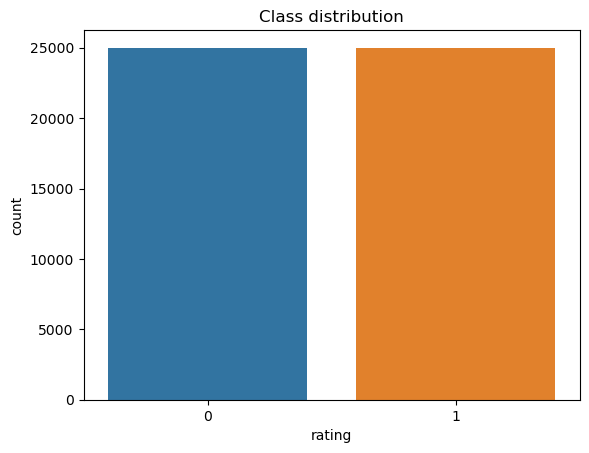

In [35]:
# Data Exploration
train_df = pd.DataFrame(dataset)
sns.countplot(x='rating', data=train_df)
plt.title('Class distribution')
plt.show()

In [39]:
dataset

{'review': {0: 'is it pretty to look at yes is it incredibly boring yes do i wish it had a purpose something to say beyond it being just another romanticised war film absolutely ',
  1: 'george clooney s movie good night and good luck about pious parson edward r murrow and sen joseph mccarthy failed to produce one person unjustly accused by mccarthy well now we know the truth decrypted soviet cables and mountains of documents from soviet archives prove beyond doubt that lawrence duggan a friend of murrow was one of stalin s most important spies mccarthyism didn t kill him his guilt did br br because of murrow s good buddy duggan innocent people were killed not just the millions murdered during the purges while duggan was earning employee of the month awards from stalin at least one man was murdered solely to protect duggan s identity as a soviet spy br br ignatz reiss had been the head of soviet secret police in europe as such he was aware of soviet agents in the u s including duggan b

In [41]:
dataset2

{0: 'is it pretty to look at yes is it incredibly boring yes do i wish it had a purpose something to say beyond it being just another romanticised war film absolutely ',
 1: 'george clooney s movie good night and good luck about pious parson edward r murrow and sen joseph mccarthy failed to produce one person unjustly accused by mccarthy well now we know the truth decrypted soviet cables and mountains of documents from soviet archives prove beyond doubt that lawrence duggan a friend of murrow was one of stalin s most important spies mccarthyism didn t kill him his guilt did br br because of murrow s good buddy duggan innocent people were killed not just the millions murdered during the purges while duggan was earning employee of the month awards from stalin at least one man was murdered solely to protect duggan s identity as a soviet spy br br ignatz reiss had been the head of soviet secret police in europe as such he was aware of soviet agents in the u s including duggan but unlike du

In [43]:
# Step 2: Preprocess the dataset
def tokenize_function(dataset):
    return tokenizer(dataset['review'].astype(str), padding="max_length", truncation=True)


dataset_revs = dataset['review']
dataset_rats = dataset['rating']
tokenized_datasets = dataset_revs.map(tokenize_function, batched=True)

AttributeError: 'dict' object has no attribute 'map'

In [45]:
tokenizer(dataset['review'].astype(str),padding="max_length",truncation=True)

AttributeError: 'dict' object has no attribute 'astype'

In [ ]:
if num_samples == -1:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)
else:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(num_samples)) 
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(num_samples)) 

In [ ]:
# Step 3: Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [ ]:
# Step 4: Define training arguments
training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch", no_cuda=True, num_train_epochs=num_epochs)

# Step 5: Create Trainer instance and train
trainer = Trainer(
    model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset
)

trainer.train()

In [ ]:
# Step 6: Evaluation
predictions = trainer.predict(small_eval_dataset)

# Confusion matrix
cm = confusion_matrix(small_eval_dataset['label'], predictions.predictions.argmax(-1))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(small_eval_dataset['label'], predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(1.618 * 5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Step 7: Inference on a new sample
sample_text = "This is a fantastic movie. I really enjoyed it."
sample_inputs = tokenizer(sample_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Move inputs to device (if GPU available)
sample_inputs.to(training_args.device)

# Make prediction
predictions = model(**sample_inputs)
predicted_class = predictions.logits.argmax(-1).item()

if predicted_class == 1:
    print("Positive sentiment")
else:
    print("Negative sentiment")

In [ ]:
import numpy as np
import pandas as pd
#import tensorflow.compat.v2 as tf
import tensorflow as tf
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from transformers import DistilBertTokenizer
from transformers import TFDistilBertModel
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast, AutoTokenizer
from sklearn.model_selection import train_test_split

max_length = 100
batch_size = 125

#sampled_df = pd.read_csv('sampled_df.csv')
sampled_df = pd.read_csv('sampled_df_bin.csv')
sampled_df['review'] = sampled_df['review'].fillna('')
sampled_df['review'] = sampled_df['review'].astype(str)
sampled_df = sampled_df[['review','rating']]

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
distil_bert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

def extract_features_in_batches(reviews, ratings, batch_size=25):
    all_res = []
    all_embeddings = []
    
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_ratings = ratings[i:i+batch_size]
        inputs = tokenizer(batch_reviews, padding=True, truncation=True, max_length=max_length, return_tensors="tf")
        outputs = distil_bert(inputs['input_ids'], attention_mask=inputs['attention_mask'], labels = 2, training = True)
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Extract embeddings
        all_embeddings.append(embeddings)
        results_seq = outputs.logits.numpy()
        
        results = outputs.logits[:,1]
        all_res.append(results)
    all_res = np.vstack(all_res)
    
   # all_embeddings = np.vstack(all_embeddings)
    return all_res


In [ ]:
X = extract_features_in_batches(sampled_df['review'].tolist(),sampled_df['rating'].tolist(), batch_size)
#X = results
y = sampled_df['rating']  # Adjust ratings to start from 0
X = X.reshape(50000,1)

# Save the bottleneck features and labels
np.save('bottleneck_embeddingswlabels.npy', X)
np.save('ratings.npy', y)

In [433]:
X = X.reshape(50000,1)
np.save('bottleneck_embeddings.npy', X)

In [46]:
X = np.load('bottleneck_embeddings.npy')

In [47]:
X

array([[-0.07536769],
       [-0.01551943],
       [-0.03848581],
       ...,
       [-0.06669383],
       [ 0.00444489],
       [-0.05702638]], dtype=float32)

In [29]:
X = np.load('bottleneck_embeddings.npy')
y = np.load('ratings.npy')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, activation='softmax', input_shape=(X.shape[1],)))
#model.add(Dense(10, activation='softmax'))  # 10 rating classes

model.add(Dense(1, activation='sigmoid'))#, input_shape=(X_train.shape[0],)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               256       
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [34]:
import time

start_time = time.time()

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2)  # Use 20% of the training data as validation data

elapsed_time = time.time() - start_time

print(f"Training took {elapsed_time:.2f} seconds.")

Epoch 1/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6930 - accuracy: 0.5067 - f1_m: 0.5584 - precision_m: 0.4958 - recall_m: 0.7465 - val_loss: 0.6930 - val_accuracy: 0.5004 - val_f1_m: 0.6326 - val_precision_m: 0.4972 - val_recall_m: 0.8806
Epoch 2/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6930 - accuracy: 0.5086 - f1_m: 0.5529 - precision_m: 0.5164 - recall_m: 0.7537 - val_loss: 0.6930 - val_accuracy: 0.5201 - val_f1_m: 0.2431 - val_precision_m: 0.5518 - val_recall_m: 0.1593
Epoch 3/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6930 - accuracy: 0.5053 - f1_m: 0.5557 - precision_m: 0.5135 - recall_m: 0.7234 - val_loss: 0.6930 - val_accuracy: 0.5142 - val_f1_m: 0.5712 - val_precision_m: 0.5065 - val_recall_m: 0.6638
Epoch 4/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6930 - accuracy: 0.5065 - f1_m: 0.4739 - precision_m: 0.5052 - recall_m: 0.6035 - val_loss: 0.6931 - val_accuracy: 0.4946 

Epoch 32/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6924 - accuracy: 0.5157 - f1_m: 0.5457 - precision_m: 0.5159 - recall_m: 0.5955 - val_loss: 0.6925 - val_accuracy: 0.5171 - val_f1_m: 0.5625 - val_precision_m: 0.5090 - val_recall_m: 0.6373
Epoch 33/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6924 - accuracy: 0.5191 - f1_m: 0.5253 - precision_m: 0.5224 - recall_m: 0.5634 - val_loss: 0.6925 - val_accuracy: 0.5144 - val_f1_m: 0.5739 - val_precision_m: 0.5065 - val_recall_m: 0.6712
Epoch 34/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6924 - accuracy: 0.5163 - f1_m: 0.5650 - precision_m: 0.5163 - recall_m: 0.6452 - val_loss: 0.6923 - val_accuracy: 0.5246 - val_f1_m: 0.4811 - val_precision_m: 0.5222 - val_recall_m: 0.4531
Epoch 35/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6923 - accuracy: 0.5185 - f1_m: 0.5311 - precision_m: 0.5206 - recall_m: 0.5587 - val_loss: 0.6925 - val_accuracy: 0.5

Epoch 93/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.5163 - f1_m: 0.5285 - precision_m: 0.5174 - recall_m: 0.5526 - val_loss: 0.6919 - val_accuracy: 0.5192 - val_f1_m: 0.5300 - val_precision_m: 0.5128 - val_recall_m: 0.5565
Epoch 94/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.5185 - f1_m: 0.5316 - precision_m: 0.5194 - recall_m: 0.5576 - val_loss: 0.6919 - val_accuracy: 0.5211 - val_f1_m: 0.5191 - val_precision_m: 0.5156 - val_recall_m: 0.5307
Epoch 95/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.5167 - f1_m: 0.5289 - precision_m: 0.5172 - recall_m: 0.5504 - val_loss: 0.6918 - val_accuracy: 0.5221 - val_f1_m: 0.5084 - val_precision_m: 0.5174 - val_recall_m: 0.5077
Epoch 96/100
500/500 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.5174 - f1_m: 0.5099 - precision_m: 0.5203 - recall_m: 0.5123 - val_loss: 0.6920 - val_accuracy: 0.5

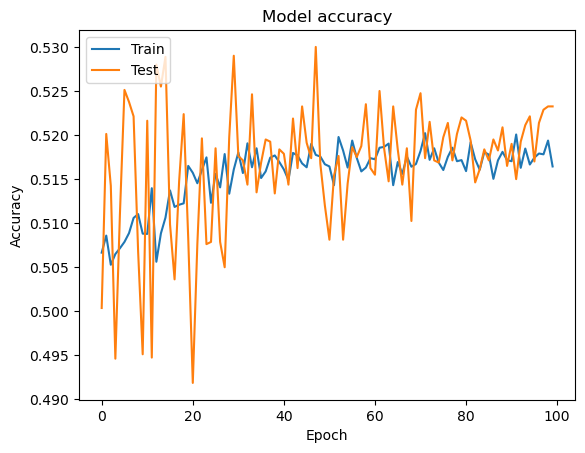

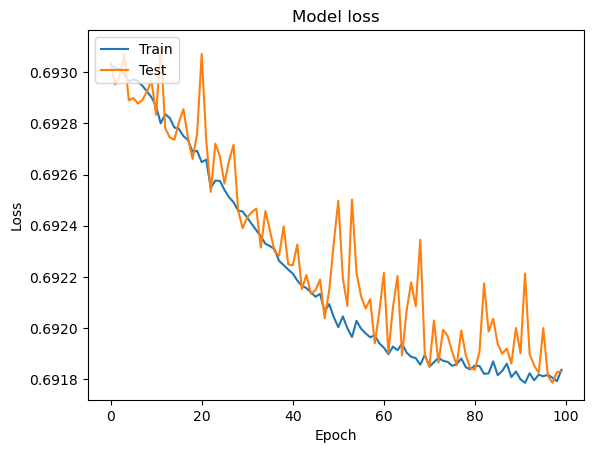

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


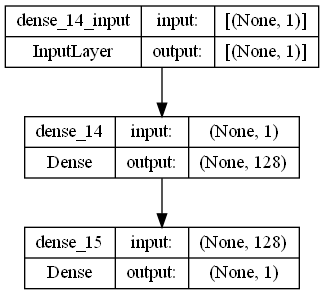

In [36]:
import keras
keras.utils.plot_model(model, to_file='distilbert_model_bin2.png', show_shapes=True, show_layer_names=True)

In [37]:
# Save the training history to a CSV file
histdf_init = pd.DataFrame(history.history)
histdf_init.to_csv('distilbert_model_training_history2bin.csv', index=False)

# Save predictions to a CSV file
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) 
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
results.to_csv('distilbert_model_training_history2bin.csv', index=False)

# Save the Keras model
model.save('distilbert_model_training_history2bin.keras')

313/313 [==============================] - 0s 562us/step


<a href="#top">Back to Top</a>
<a id="P6"></a>
## 6.0 Fine-Tuning the Model 
#### Perform fine tuning upon the model by training some layers within the foundational model. Verify that the model converges. 

One approach to performing this can be found in: https://classic.d2l.ai/chapter_natural-language-processing-applications/finetuning-bert.html.


In [24]:
# Load y and y_pred
results = pd.read_csv('distilbert_model_predictions.csv')

# Load the training history
histdf = pd.read_csv('distilbert_model_training_history.csv')

<a href="#top">Back to Top</a>
<a id="P7"></a>
## 7.0 Results: Comparing All Investigated Models 
#### Report the results of all models using the evaluation procedure that you argued for at the beginning of the lab. Compare the convergence of the models and the running time. Results should be reported with proper statistical comparisons and proper visualizations.
xx